### Analysis of Indel Recombitron data 

#### Sequence based analysis (not relying on CRISPResso)

In [5]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil
from functions_ import *

In [6]:
### define the necessary variables

base_dir = os.getcwd() 
amplicon = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"

amplicon_DNA = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'

amplicon_DNA_corrected = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'## since all the sequenced reads have an "A" instead of "G" at the 413th position of the LOV2 gene, we correct the sequence here

amplicon_start = "CGCCGCATGGAAGCGATTAACGAAAGCAGCGGT"
amplicon_end = "GGGAGCCTGCATCCGCCGATGGATAACCGCGTG"
LOV_gene_end = "ACATTGATGAAGCGGCCAAA"

LOV_gene = "TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAA"

LOV_gene_corrected = 'TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAA' ## since all the sequenced reads have an "A" instead of "G" at the 413th position, we correct the sequence here

LOV = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"

gene_len = len(LOV)*3
catch_left = 'AAGCAGCGGT'
catch_right = 'GGGAGCCTGC'
offset_left = 3
offset_right= 5

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [7]:
### read sequences from fastq files

a_seqs, b_seqs = read_sequences("RL1", catch_left="", catch_right="")

target_R1 = "TTAGCCACA" ## seq right after linker 1
target_R2 = "GCGGCCAAA" ## seq right before linker 2

print("a_seq with target:", sum(target_R1 in seq for seq in a_seqs))
print("b_seq with target:", sum(dna_rev_comp(target_R2) in seq for seq in b_seqs))

b_seqs_comp = [dna_rev_comp(seq) for seq in b_seqs]

total reads 48196
a_seq with target: 29251
b_seq with target: 23129


In [8]:
insertions = [#"X",
   #"GG",
   # "PP",
    #"GXG"
   "GGSG",
   "GSGG",
   "GPPG",
   "GSGSG",
   "GPPPG",
   "GSGGSG",
   "GPPPPG"] + ["G"+x+"G" for x in ecoli_pref.keys()] # + "GXG" AAs ## !!! "X" insertions are not included here, also "PP" and "GG" are not included here


insertion_codons = {insertion : "".join([ecoli_pref[Aa] for Aa in insertion]) for insertion in insertions }
subst = {Aa: "".join([ecoli_pref[a] for a in Aa]) for Aa in ["GG", "PP"]}
deletions = {"del1": "-"*9, # deletion of SG + deletion of the AA in front = total of 9 nucleotides
             "del2": "-"*12,
             "del3": "-"*15,}

In [9]:
intended_changes = list(insertion_codons.values()) + list(subst.values())+ list(ecoli_pref.values())

In [10]:
def get_linker_variants(reads, 
                        seq_before_linker, 
                        seq_after_linker, 
                        total_seq,  
                        wt_linker, 
                        intended_changes,
                        adaptor_left,
                        rev_reads,
                        include_changes_after_linker = False, 
                        include_deletions = True, 
                        combine_other = True, 
                        filter_treshold = 0.05
                        ):
    """
    get linker variants

    reads: list of sequences (if R2 read, call dna_rev_comp on the sequences prior to calling this function)
    seq_before_linker: short DNA sequence before the linker (8-10 bp)
    seq_after_linker: short DNA sequence after the linker
    wt_linker: linker DNA sequence
    total_seq_before_linker: sequence from the beginning of the read until the linker sequence
    intended_changes: indels and mutations (deletions are handeled separately) that are intended to be introduced by the retron library
    rev_reads: whether or not the reads are from the R2 read (on which dna_rev_comp was called already) (default: False)
    include_changes_after_linker: whether or not to include reads that do not contain the sequence after linker, but are in principle long enough, in the analysis (default: False) -> are counted within "other" --> probably due to unintended changes (off-target retron editing), mutations or sequencing errors (intended changes are all located prior to or in the linker sequence, i.e. the sequence after the linker should not be affected by the retron editing)
    include_deletions: whether or not to include deletions in the analysis (default: True) 
    combine_other: whether or not to combine all "other" (not intended) sequences into one category (default: True)
    filter_treshold: variants with frequency below filter_treshold (given in %) are filtered out (default: 0.05)

    returns: dictionaries with (1) counts, (2) percents of linker variants, (3) percents of linker variants for AAs
    """
    print("total reads",len(reads)) # number of sequences
    print("reads with target sequence", sum([seq_after_linker in seq for seq in reads])) ## sum of seqences that include the sequence after the linker

    linker_variants = {}

    for seq in reads:   ## indels and mutations
        if seq_before_linker in seq and seq_after_linker in seq: ## only consider reads that contain the linker position
            start_idx = seq.index(seq_before_linker) + len(seq_before_linker)
            stop_idx = seq.index(seq_after_linker)
            linker = seq[start_idx:stop_idx]

            if linker in intended_changes: ## include intended changes
                if linker in linker_variants.keys():
                    linker_variants[linker] += 1
                else: 
                    linker_variants[linker] = 1

            elif linker == wt_linker:
                if "wt" in linker_variants.keys():
                    linker_variants["wt"] += 1  
                else: 
                    linker_variants["wt"] = 1
                
            else:  ### include changes not intended to "other" category
                if combine_other: 
                    if "other" in linker_variants.keys():
                        linker_variants["other"] += 1
                    else: 
                        linker_variants["other"] = 1
                elif "other_" + linker in linker_variants.keys():
                    linker_variants["other_" + linker] += 1
                else: 
                    linker_variants["other_" + linker] = 1

        elif include_deletions: ## deletions
            deleted_seq = seq_before_linker if not rev_reads else seq_after_linker ## sequence that is deleted (before or after depending on the read orientation)
            intact_seq = seq_after_linker if not rev_reads else seq_before_linker ## sequence that is not deleted (before or after depending on the read orientation)
            if intact_seq in seq and deleted_seq not in seq: ## because for deletions, we delete at least three bases from the seq before the linker, i.e. seq_before linker is not anymore completely in seq
                seq_until_deletion = seq[len(adaptor_left):seq.index(intact_seq)] if not rev_reads else seq[seq.index(intact_seq)+len(intact_seq):-len(adaptor_left)] ## sequence with deletion
                #if seq_with_deletion in total_seq:
                #print(len(total_seq), seq_with_deletion)
                del_len = len(seq_until_deletion) - (len(total_seq)+len(wt_linker))
                #print(seq_with_deletion, del_len)
                if del_len <=0: ## no insertion but mutations in seq_before_linker, thus seq_before_linker is not in seq but we do not want to consider these reads
                    #print(seq_until_deletion)
                    #print(del_len, seq)
                    delname = "del"+str(del_len) if del_len !=0 else "del-0"
                    if seq_until_deletion in total_seq: ## only consider deletions that are in the total sequence (i.e. deletions that are not due to sequencing errors)
                        if delname in linker_variants.keys():
                            linker_variants[delname] += 1
                        else:
                            linker_variants[delname] = 1
                    else: 
                        if del_len == 0:
                            if "other" in linker_variants.keys():
                                linker_variants["other"] += 1
                            else:
                                linker_variants["other"] = 1
                        elif "other_"+delname in linker_variants.keys():
                            linker_variants["other"+delname] += 1
                        else:
                            linker_variants["other"+delname] = 1
                    

        elif include_changes_after_linker: ## other (untargeted changes that effect the sequence after the linker)
            if len(seq) >= len(total_seq)+len(wt_linker)+len(seq_after_linker):
                if "after_linker" not in linker_variants.keys():
                    linker_variants["after_linker"] = 1
                else:
                    linker_variants["after_linker"] += 1

    total_vars = sum(linker_variants.values())
    ### percentage
    linker_variants_perc = {seq: count/total_vars*100 for seq,count in linker_variants.items()}
    ## exclude everything below given filter_treshold
    linker_variants_perc = {seq: count for seq,count in linker_variants_perc.items() if count > filter_treshold}
    ## order after value size
    linker_variants_perc = dict(sorted(linker_variants_perc.items(), key = lambda x: x[1], reverse = True))
    ### convert dict keys to AAs
    linker_variants_perc_AA = {(translate_dna2aa(seq) if seq[0] in ["A","C","G","T"] else seq) : count for seq,count in linker_variants_perc.items()}
    linker_variants_perc_AA = dict(sorted(linker_variants_perc_AA.items(), key = lambda x: x[1], reverse = True))

    return linker_variants, linker_variants_perc, linker_variants_perc_AA

In [30]:
adaptor_left = "CCC" ## for a_seq
seq_before_linker = "TTAACGAAAGC"
seq_after_linker = "TTAGCCACAA"
total_seq = "cgccgCATGGAAGCGATTAACGAAAGC".upper()#"GCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCT" # sequence from primer until linker
linker_seq = "AGCGGT" 
reads = a_seqs

linker_vars, linker_vars_perc, linker_AA_perc = get_linker_variants(reads=reads, seq_before_linker=seq_before_linker, seq_after_linker=seq_after_linker, total_seq=total_seq,  wt_linker=linker_seq, include_changes_after_linker = True, include_deletions = True, intended_changes = intended_changes, combine_other = False, adaptor_left=adaptor_left, filter_treshold = 0.05, rev_reads=False)

total reads 48196
reads with target sequence 29202


In [13]:
linker_vars_perc

{'wt': 86.04707177757896,
 'other_AGCGGC': 0.7742068680751497,
 'CAG': 0.43011492670841656,
 'AGC': 0.42667400729474914,
 'TGG': 0.40258757139907786,
 'CCG': 0.40258757139907786,
 'TGC': 0.3991466519854105,
 'GTG': 0.3991466519854105,
 'CTG': 0.3681783772624045,
 'CGT': 0.3578556190214025,
 'GGC': 0.34065102195306585,
 'ACC': 0.34065102195306585,
 'GCG': 0.33032826371206386,
 'AAC': 0.3165645860573945,
 'TTT': 0.29935998898905786,
 'ATG': 0.2890372307480559,
 'ATT': 0.2787144725070539,
 'GGCATGGGC': 0.2752735530933865,
 'AAA': 0.2683917142660519,
 'GGCGTGGGC': 0.26495079485238454,
 'GAA': 0.25806895602504987,
 'CAT': 0.25806895602504987,
 'GGCTGGGGC': 0.25806895602504987,
 'GGCGATGGC': 0.25806895602504987,
 'GGCTGCGGC': 0.25462803661138256,
 'GGCGAAGGC': 0.24086435895671324,
 'TAT': 0.24086435895671324,
 'GGCTATGGC': 0.24086435895671324,
 'GGCGGCGGC': 0.23398252012937856,
 'GGCAGCGGC': 0.23054160071571123,
 'GGCAAAGGC': 0.22710068130204392,
 'GAT': 0.22710068130204392,
 'GGCCATGGC': 0.

In [21]:
adaptor_left = "CCCC" # for b_seq
seq_before_linker = "GCGGCCAAA"
seq_after_linker ="CTGCATCC"
total_seq = "CTGCATCCGCCGATGGATAACCGcgtgc".upper()
linker_seq = "GGGAGC" 
reads = b_seqs_comp
linker_vars, linker_vars_perc, linker_AA_perc = get_linker_variants(reads=reads, seq_before_linker=seq_before_linker, seq_after_linker=seq_after_linker, total_seq=total_seq,  wt_linker=linker_seq, include_changes_after_linker = True, include_deletions = True, intended_changes = intended_changes, combine_other = False, adaptor_left=adaptor_left, filter_treshold = 0.05, rev_reads=True)

total reads 48196
reads with target sequence 36820


In [15]:
linker_AA_perc

{'wt': 71.95413282369803,
 'V': 0.9164748295183078,
 'P': 0.8513225904530252,
 'W': 0.8382921426399688,
 'L': 0.8339486600356166,
 'R': 0.7557659731572774,
 'F': 0.7340485601355167,
 'GGSG': 0.7079876645094036,
 'M': 0.6558658732571776,
 'T': 0.6515223906528254,
 'Q': 0.6428354254441211,
 'A': 0.6341484602354168,
 'C': 0.6254614950267124,
 'Y': 0.5994005994005994,
 'GVG': 0.5994005994005994,
 'E': 0.5950571167962472,
 'I': 0.5863701515875429,
 'GYG': 0.5820266689831907,
 'D': 0.5820266689831907,
 'H': 0.5733397037744864,
 'GHG': 0.5733397037744864,
 'GQG': 0.5689962211701342,
 'GPG': 0.564652738565782,
 'GKG': 0.564652738565782,
 'GMG': 0.5472788081483734,
 'GGG': 0.5472788081483734,
 'S': 0.5255613951266125,
 'GWG': 0.5212179125222604,
 'GSGG': 0.5038439821048517,
 'GCG': 0.49515701689614733,
 'N': 0.4908135342917952,
 'GLG': 0.4908135342917952,
 'GIG': 0.4908135342917952,
 'GRG': 0.486470051687443,
 'GEG': 0.486470051687443,
 'GFG': 0.46040915606133,
 'GAG': 0.44737870824827347,
 'GN

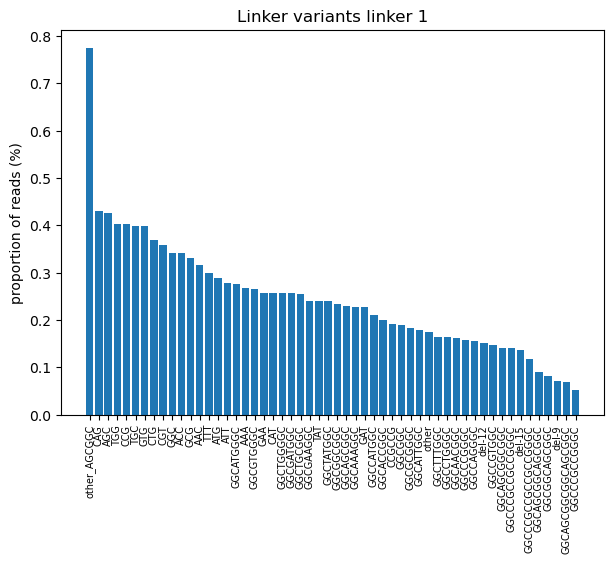

In [33]:
plt.figure(figsize=(7,5))
plt.bar(list(linker_vars_perc.keys()), list(linker_vars_perc.values()))
plt.title("Linker variants linker 1")
plt.xticks(rotation=90, fontsize = 7)
plt.ylabel("proportion of reads (%)")  
plt.savefig("output/RL1/linker_R1_indel_Nt_freq.pdf", bbox_inches = "tight")    
plt.show()

In [32]:
## exclude wt 
linker_vars_perc = {seq: count for seq,count in linker_vars_perc.items() if seq != "wt"}
for change in intended_changes + ["del-9", "del-12", "del-15"]:
    print(change in linker_vars_perc.keys()) if change not in linker_vars_perc.keys() else None
    if change not in linker_vars_perc.keys():
        linker_vars_perc[change] = 0
        
linker_AA_perc  = {seq: count for seq,count in linker_AA_perc.items() if seq != "wt"}
for change in intended_changes + ["del-9", "del-12", "del-15"]:
    change = translate_dna2aa(change) if change[0] in ["A","C","G","T"] else change
    print(change in linker_AA_perc.keys()) if change not in linker_AA_perc.keys() else None
    if change not in linker_AA_perc.keys():
        linker_AA_perc[change] = 0

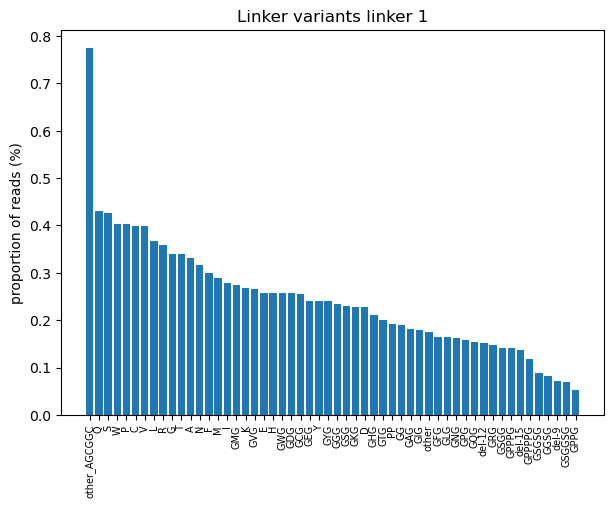

In [34]:
plt.figure(figsize=(7,5))
plt.bar(list(linker_AA_perc.keys()), list(linker_AA_perc.values()))
plt.title("Linker variants linker 1")
plt.xticks(rotation=90, fontsize = 7)
plt.ylabel("proportion of reads (%)")  
plt.savefig("output/RL1/linker_R1_indel_AA_freq.pdf", bbox_inches = "tight")    
plt.show()

In [35]:
for key in linker_vars_perc.keys():
    print(key, linker_vars[key])

other_AGCGGC 225
CAG 125
AGC 124
TGG 117
CCG 117
TGC 116
GTG 116
CTG 107
CGT 104
GGC 99
ACC 99
GCG 96
AAC 92
TTT 87
ATG 84
ATT 81
GGCATGGGC 80
AAA 78
GGCGTGGGC 77
GAA 75
CAT 75
GGCTGGGGC 75
GGCGATGGC 75
GGCTGCGGC 74
GGCGAAGGC 70
TAT 70
GGCTATGGC 70
GGCGGCGGC 68
GGCAGCGGC 67
GGCAAAGGC 66
GAT 66
GGCCATGGC 61
GGCACCGGC 58
CCGCCG 56
GGCGGC 55
GGCGCGGGC 53
GGCATTGGC 52
other 51
GGCTTTGGC 48
GGCCTGGGC 48
GGCAACGGC 47
GGCCCGGGC 46
GGCCAGGGC 45
del-12 44
GGCCGTGGC 43
GGCAGCGGCGGC 41
GGCCCGCCGCCGGGC 41
del-15 40
GGCCCGCCGCCGCCGGGC 34
GGCAGCGGCAGCGGC 26
GGCGGCAGCGGC 24
del-9 21
GGCAGCGGCGGCAGCGGC 20
GGCCCGCCGGGC 15
